# ECE 228 Unet (mitochondria dataset)

# Python Imports

In [1]:
import numpy as np
import os
import sys
from matplotlib import pyplot as plt
%matplotlib inline  

import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms, utils
from skimage import io, transform
from skimage.color import rgb2gray

from models import * 



# Load Mitochondria Data

/datasets/home/89/189/ltindall/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Train imgs shape =  (20, 512, 512)
Validation imgs shape =  (10, 512, 512)
Test imgs shape =  (5, 1024, 1024)


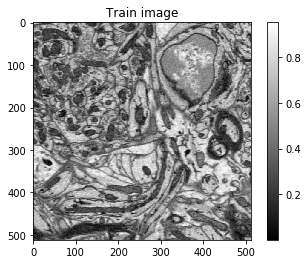

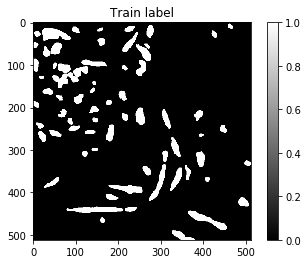

In [2]:
mito_dir = './datasets/mitochondria/'

def import_mito(mito_dir): 
    
    mito_train_img_dir = mito_dir+'training/images/'
    mito_train_lbl_dir = mito_dir+'training/labels/'   
    mito_val_img_dir = mito_dir+'validation/images/'
    mito_val_lbl_dir = mito_dir+'validation/labels/'
    mito_test_img_dir = mito_dir+'testset/'

    # load train imgs and labels 
    mito_train_imgs = import_dir(mito_train_img_dir)
    mito_train_lbls = import_dir(mito_train_lbl_dir)
   
    # convert train labels to binary mask
    mito_train_lbls_gray = []
    for img in mito_train_lbls:
        mito_train_lbls_gray.append(rgb2gray(img))
    mito_train_lbls = np.array(mito_train_lbls_gray)
    mito_train_lbls[mito_train_lbls!=0]=1
    
    # load validation imgs and labels 
    mito_val_imgs = import_dir(mito_val_img_dir)
    mito_val_lbls = import_dir(mito_val_lbl_dir)
    
    # convert validation labels to binary masks 
    mito_val_lbls_gray = []
    for img in mito_val_lbls:
        mito_val_lbls_gray.append(rgb2gray(img))
    mito_val_lbls = np.array(mito_val_lbls_gray)
    mito_val_lbls[mito_val_lbls!=0]=1
    
    # load test imgs 
    mito_test_imgs = import_dir(mito_test_img_dir)
    
    
    return mito_train_imgs, mito_train_lbls, mito_val_imgs, mito_val_lbls, mito_test_imgs

def import_dir(dirn): 
    
    files = [f for f in os.listdir(dirn) if os.path.isfile(os.path.join(dirn, f))]
    files.sort()
    
    imgs = []
    for f in files: 
        imgs.append(plt.imread(dirn+f))
    return np.array(imgs)
    


mito_train_imgs, mito_train_lbls, mito_val_imgs, mito_val_lbls, mito_test_imgs = import_mito(mito_dir)


resize_size = 512
mito_train_imgs_resized = []
mito_train_lbls_resized = []
mito_val_imgs_resized = []
mito_val_lbls_resized = []
for (img,lbl) in zip(mito_train_imgs, mito_train_lbls): 
    mito_train_imgs_resized.append(transform.resize(img,(resize_size,resize_size)))
    mito_train_lbls_resized.append(transform.resize(lbl,(resize_size,resize_size)))
for (img,lbl) in zip(mito_val_imgs, mito_val_lbls): 
    mito_val_imgs_resized.append(transform.resize(img,(resize_size,resize_size)))
    mito_val_lbls_resized.append(transform.resize(lbl,(resize_size,resize_size)))
    
mito_train_imgs = np.array(mito_train_imgs_resized)
mito_train_lbls = np.array(mito_train_lbls_resized)

mito_val_imgs = np.array(mito_val_imgs_resized)
mito_val_lbls = np.array(mito_val_lbls_resized)
    


print("Train imgs shape = ",mito_train_imgs.shape)
print("Validation imgs shape = ",mito_val_imgs.shape)
print("Test imgs shape = ",mito_test_imgs.shape)

plt.imshow(mito_train_imgs[0], cmap="gray")
plt.title("Train image")
plt.colorbar()
plt.show()

plt.imshow(mito_train_lbls[0], cmap="gray")
plt.title("Train label")
plt.colorbar()
plt.show()

# Training methods

In [3]:
def f1_score(y_true, y_pred, threshold):


    y_pred = (y_pred >= threshold).astype(np.uint8)
    true_positive = np.sum(y_pred * y_true)

    total_positive = np.sum(y_pred)
    precision = true_positive/total_positive if total_positive != 0 else 0

    total_true = np.sum(y_true)
    recall = true_positive/total_true if total_true != 0 else 0
        

    return (2*precision*recall)/(precision+recall) if (precision+recall) != 0 else 0


def eval_net(model, inputs, targets): 
    model.eval()
    
    avg_loss = 0
    avg_f1_score = 0
    n = 0
    for (img,lbl) in zip(inputs,targets): 
            
        # get batch of images and labels 
        #imgs = inputs[i*batch_size:(i+1)*batch_size]
        #lbls = targets[i*batch_size:(i+1)*batch_size]

        
        # convert to pytorch cuda variable 
        x = Variable(torch.FloatTensor(img)).detach()
        target = Variable(torch.FloatTensor(lbl)).detach()
        if GPU: 
            x = x.cuda()
            target = target.cuda()

        x = torch.unsqueeze(x,0)
        x = torch.unsqueeze(x,0)
        target = torch.unsqueeze(target, 0)
        target = torch.unsqueeze(target, 0)
        

        
        # get output and loss 
        output = model(x)
        loss = criterion(output, target)

        print(loss.data[0])
        avg_loss += loss.data[0]

        f1 = f1_score(lbl, output.data.cpu().numpy(), 0.1)
        
        avg_f1_score += f1
        
        n += 1 


    avg_loss /= len(targets)
    avg_f1_score /= len(targets)

    model.train()
    
    return avg_loss, avg_f1_score
    
    

In [4]:
# Prep GPU
GPU = torch.cuda.is_available()
print("GPU is {}enabled ".format(['not ', ''][GPU]))

batch_size = 1

def training(model, inputs, targets,val,val_target, epochs):
    # set training mode
    model.train()
    
    num_batches = int(len(inputs) / batch_size)
    
    for epoch in range(epochs): 
        
        avg_loss = 0
        for i in range(num_batches):
            
            if i*batch_size >= len(inputs):
                break
            
            # get batch of images and labels 
            imgs = inputs[i*batch_size:(i+1)*batch_size]
            lbls = targets[i*batch_size:(i+1)*batch_size]
           

            # resize and expand imgs according to pytorch convention (N, channels, height, width)
            #img = transform.resize(img, (new_size, new_size))
            imgs = np.expand_dims(imgs, axis=1)

            #lbl = transform.resize(lbl, (new_size, new_size))
            lbls = np.expand_dims(lbls, axis=1)
            

            
            # create pytorch cuda variables 
            x = Variable(torch.FloatTensor(imgs))
            target = Variable(torch.FloatTensor(lbls))
            
            if GPU: 
                x = x.cuda()
                target = target.cuda()

                
            # get output and loss
            output = model(x)
            loss = criterion(output, target)
            
            # backpropagate 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(loss.data[0])
            avg_loss += loss.data[0]
            #print("loss = ",loss.data[0])
            
            #num_batches += 1
  

        avg_loss /= num_batches

        print('epoch: ' + str(epoch) + ', train loss: ' + str(avg_loss))
        
        
        

        # do one random prediction 
        i = np.random.randint(0,val.shape[0])
        #val_img = transform.resize(val[i], (new_size,new_size))
        val_img = val[i]
        val_img = np.expand_dims(val_img, axis=0)
        val_img = np.expand_dims(val_img, axis=0)
        val_img = Variable(torch.FloatTensor(val_img))
        if GPU: 
            val_img = val_img.cuda()
        prediction = model(val_img)
        prediction = prediction.data.cpu().numpy()
        prediction = prediction.squeeze()
        

        # plot prediction and real label 
        f, (ax1,ax2) = plt.subplots(1,2, sharey=True,figsize=(15,15), dpi=80)
        ax1.imshow(prediction, cmap="gray")
        ax1.set_title("Prediction")
        ax2.imshow(val_target[i], cmap="gray")
        ax2.set_title("Real label")
        plt.show()
        
        if epoch % 10 == 0: 
            train_avg_loss, train_avg_f1_score = eval_net(model, inputs, targets)
            val_avg_loss, val_avg_f1_score = eval_net(model, val, val_target)
            print("Network evaluation at epoch: ",epoch,"\ntrain_avg_loss = ",train_avg_loss,", train_avg_f1_score = ",train_avg_f1_score,
                  "\nval_avg_loss = ", val_avg_loss,", val_avg_f1_score = ",val_avg_f1_score)
        
        


GPU is enabled 


# Run Training 

0.6777685880661011
0.5979384779930115
0.5468489527702332
0.48580583930015564
0.4317985475063324
0.3886265158653259
0.34940218925476074
0.3160339891910553
0.2900563180446625
0.2668764591217041
0.25316232442855835
0.2355891764163971
0.22056353092193604
0.19913549721240997
0.19146780669689178
0.2007555365562439
0.19682517647743225
0.19869068264961243
0.19177940487861633
0.18984749913215637
epoch: 0, train loss: 0.32144862562417986


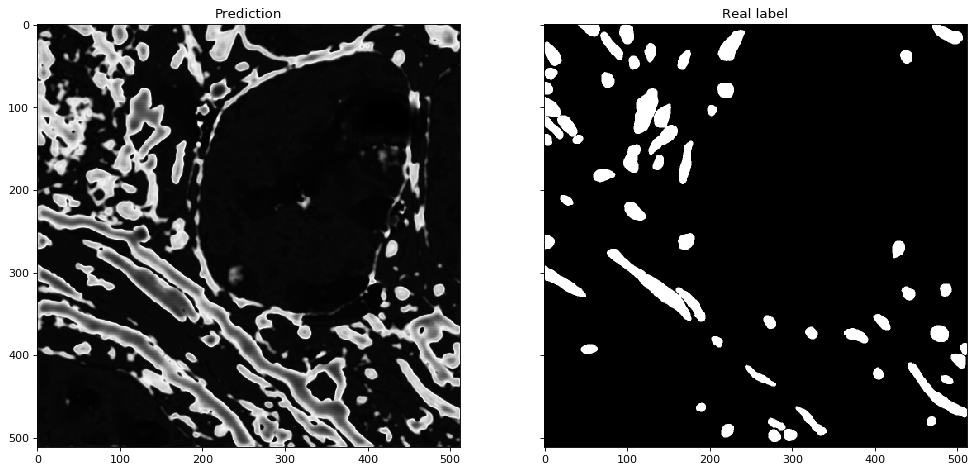

2.506131410598755
2.2734293937683105
2.3211679458618164
2.272472620010376
2.1471378803253174
1.9863852262496948
2.129542112350464
1.826996922492981
1.9854772090911865
2.043637275695801
2.3067984580993652
2.174748420715332
2.099956750869751
1.830391764640808
1.983025074005127
2.2256200313568115
2.1959340572357178
2.371577739715576
2.2371673583984375
2.2914984226226807
2.2091357707977295
2.104810953140259
1.9840619564056396
1.9605004787445068
1.964796781539917
1.8687885999679565
1.8031128644943237
1.689734935760498
1.641036868095398
1.6553341150283813
Network evaluation at epoch:  0 
train_avg_loss =  2.1604548037052154 , train_avg_f1_score =  0.04978847084743286 
val_avg_loss =  1.888131332397461 , val_avg_f1_score =  0.046488659042869106
0.2227783054113388
0.19307121634483337
0.18746165931224823
0.18151699006557465
0.17610742151737213
0.16838403046131134
0.16816668212413788
0.156344473361969
0.16163216531276703
0.16528984904289246
0.17187219858169556
0.1649869680404663
0.15194255113601

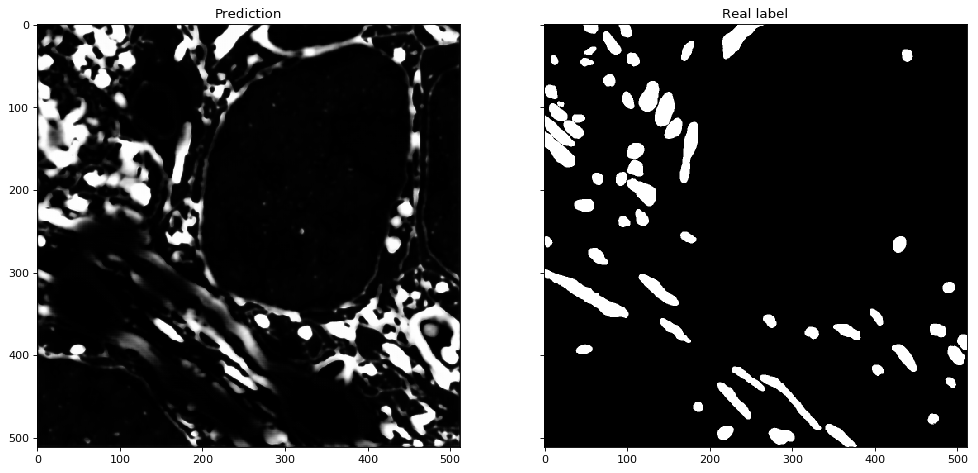

0.2004079520702362
0.16457009315490723
0.16397425532341003
0.16325247287750244
0.16243302822113037
0.1568349450826645
0.15850414335727692
0.1444552093744278
0.14855828881263733
0.15274035930633545
0.15200290083885193
0.13936395943164825
0.12972480058670044
0.12266355752944946
0.12757636606693268
0.13737159967422485
0.12995149195194244
0.13261117041110992
0.1330699622631073
0.12378368526697159
epoch: 2, train loss: 0.14719251208007336


KeyboardInterrupt: 

In [5]:

# unet(n_channels, n_classes, n_filters_start=64 )
un = unet(1,1)

if GPU: 
    un = un.cuda()

optimizer = torch.optim.Adam(un.parameters(), lr=0.01)
criterion = nn.BCELoss()

# training(model, inputs, targets,val,val_target, epochs)
training(un,mito_train_imgs, mito_train_lbls, mito_val_imgs, mito_val_lbls, 1000)

In [ ]:
whos

In [ ]:
import torch
print(torch.__version__)

# todo


1. accuracy

2. batches

3. disconnecting objects
